## Import Statements

In [337]:
import pandas as pd
import math
from sklearn import linear_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import scatter_matrix

## Reading the data file

In [292]:
kepler_data = pd.read_csv("Ex01_Kepler_Regression.csv")

In [293]:
kepler_data.is_copy=False

In [295]:
kepler_data['planet'] = pd.Categorical(kepler_data.planet).codes

In [296]:
kepler_data = kepler_data.drop('planet', axis=1)

In [297]:
kepler_data = kepler_data.apply(lambda x: np.log(x))

## Basic Analysis

In [9]:
kepler_data.corr()

,SemiMajorAxis,Volume,EscapeVelocity,Density,OrbitalPeriod
SemiMajorAxis,1.000000,0.259847,0.726331,-0.874480,0.991669
Volume,0.259847,1.000000,0.150367,-0.301006,0.227032
EscapeVelocity,0.726331,0.150367,1.000000,-0.785451,0.709807
Density,-0.874480,-0.301006,-0.785451,1.000000,-0.864849
OrbitalPeriod,0.991669,0.227032,0.709807,-0.864849,1.000000


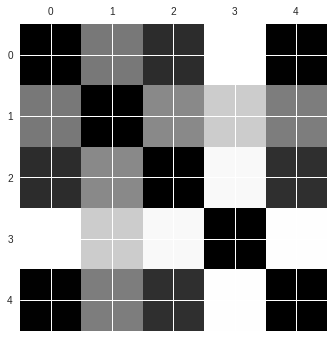

In [10]:
plt.matshow(kepler_data.corr())
plt.show()

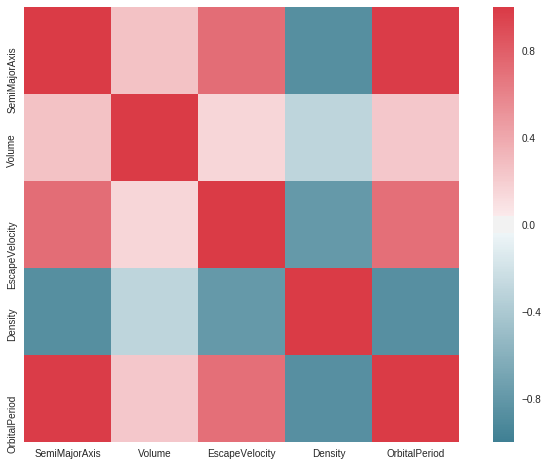

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
corr = kepler_data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Scatter plots regressors vs regressand

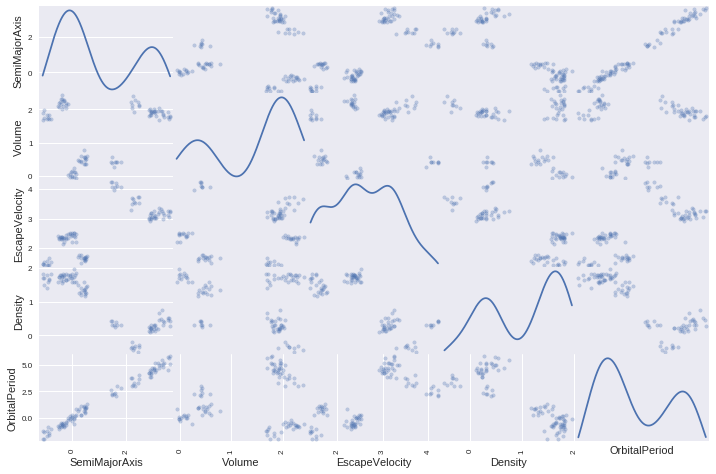

In [342]:
scatter_matrix(kepler_data, alpha=0.3, figsize=(12, 8), diagonal='kde')
plt.xticks(())
plt.yticks(())
plt.show()

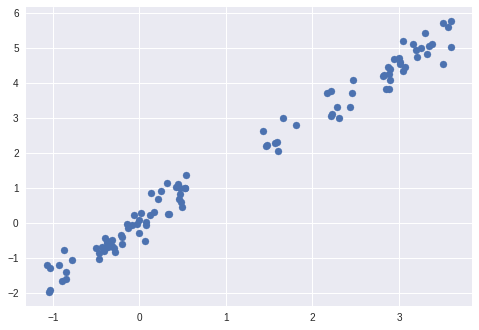

In [12]:
plt.scatter(kepler_data.SemiMajorAxis, kepler_data.OrbitalPeriod)
plt.show()

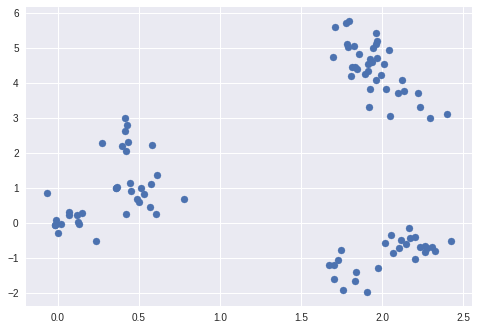

In [13]:
plt.scatter(kepler_data.Volume, kepler_data.OrbitalPeriod)
plt.show()

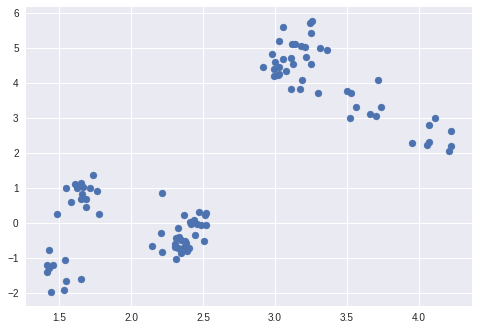

In [14]:
plt.scatter(kepler_data.EscapeVelocity, kepler_data.OrbitalPeriod)
plt.show()

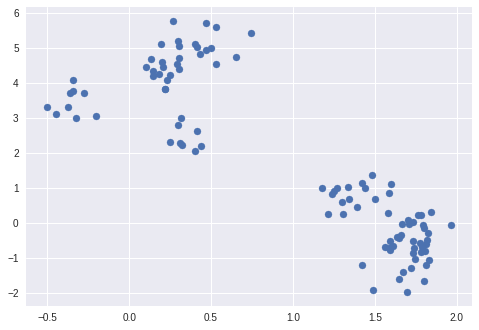

In [15]:
plt.scatter(kepler_data.Density, kepler_data.OrbitalPeriod)
plt.show()

## Making Train and Test Datasets

In [298]:
kepler_data_y = kepler_data['OrbitalPeriod']
kepler_data_x = kepler_data.drop(['OrbitalPeriod'], axis=1)

In [299]:
kepler_data_x_train = kepler_data_x[:int(0.6*len(kepler_data_x))]
kepler_data_y_train = kepler_data_y[:int(0.6*len(kepler_data_y))]
kepler_data_x_test = kepler_data_x[int(0.6*len(kepler_data_x)):]
kepler_data_y_test = kepler_data_y[int(0.6*len(kepler_data_y)):]

## Standardising the data

In [300]:
kepler_data_stan_y_train = (kepler_data_y_train-kepler_data_y_train.mean())/kepler_data_y_train.std()
kepler_data_stan_x_train = (kepler_data_x_train-kepler_data_x_train.mean())/kepler_data_x_train.std()
kepler_data_stan_x_test = (kepler_data_x_test-kepler_data_x_test.mean())/kepler_data_x_test.std()

Non-standardised datasets - just to verify the model is working fine (matching the coeffs to the generative equation given)

In [301]:
# kepler_data_stan_y_train = kepler_data_y_train
# kepler_data_stan_x_train = kepler_data_x_train
# kepler_data_stan_x_test = kepler_data_x_test

## Linear Regression Model

In [302]:
reg = linear_model.LinearRegression(normalize=True)
reg.fit (kepler_data_stan_x_train, kepler_data_stan_y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [303]:
tr_coeffs = reg.coef_
tr_resi = reg.residues_
tr_intr = reg.intercept_
print(pd.Series(tr_coeffs, index=kepler_data_stan_x_test.columns))
print("Residuals: ", tr_resi)
print("Intercept: ", tr_intr)

SemiMajorAxis     0.993534
Volume           -0.033229
EscapeVelocity   -0.046174
Density          -0.045480
dtype: float64
Residuals:  0.732979031582
Intercept:  1.63574550894e-16


/home/user/StackRoute/Assignments/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [304]:
pred_lin = reg.predict(kepler_data_stan_x_test)

In [305]:
pred_lin = (pred_lin*kepler_data_y_test.std())+kepler_data_y_test.mean()

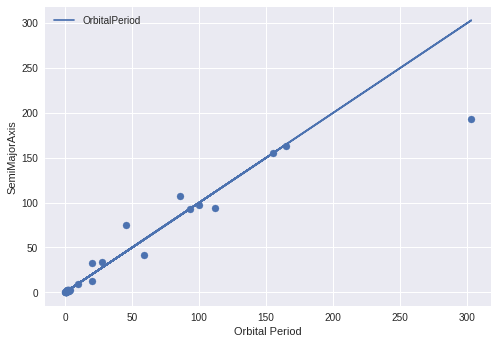

In [345]:
plt.scatter(np.exp(kepler_data_y_test), np.exp(pred_lin))
plt.plot(np.exp(kepler_data_y_test), np.exp(kepler_data_y_test))
plt.legend()
plt.xticks()
plt.yticks()
plt.xlabel('Orbital Period')
plt.ylabel('SemiMajorAxis')
plt.show()

In [307]:
errors_abs = np.abs(np.exp(kepler_data_y_test)-np.exp(pred_lin))
errors = np.exp(kepler_data_y_test)-np.exp(pred_lin)

In [308]:
errors.mean()

2.1869690850722665

/home/user/StackRoute/Assignments/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


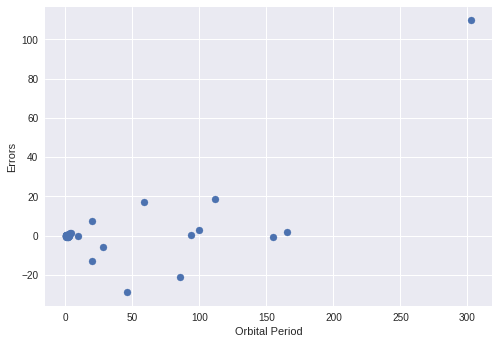

In [349]:
plt.scatter(np.exp(kepler_data_y_test), errors)
plt.legend()
plt.xlabel('Orbital Period')
plt.ylabel('Errors')
plt.show()

## Linear Regression Model : Ridge

In [330]:
alphas_r = np.linspace(0.01,200,1000)*0.5

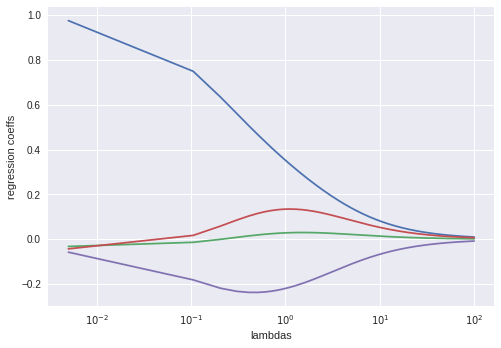

In [350]:
ridge = linear_model.Ridge(normalize=True)
coefs = []
for a in alphas_r:
    ridge.set_params(alpha=a)
    ridge.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
    coefs.append(ridge.coef_)
ax = plt.gca()
ax.plot(alphas_r, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambdas')
plt.ylabel('regression coeffs')
plt.show()

In [333]:
ridgecv = linear_model.RidgeCV(alphas=alphas_r, scoring='neg_mean_squared_error', normalize=True)
ridgecv.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
ridgecv.alpha_
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
pred = ridge.predict(kepler_data_stan_x_test)
mean_squared_error(np.exp(kepler_data_y_test), np.exp((pred*kepler_data_y_test.std())+kepler_data_y_test.mean()))

399.59037042752431

In [334]:
print(pd.Series(ridge.coef_, index=kepler_data_stan_x_test.columns))
print("Intercept: ", ridge.intercept_)
print("Aplha: ", ridge.alpha)

SemiMajorAxis     0.975648
Volume           -0.032316
EscapeVelocity   -0.043135
Density          -0.057930
dtype: float64
Intercept:  1.58666850493e-16
Aplha:  0.005


In [335]:
pred_ridge = np.exp((ridge.predict(kepler_data_stan_x_test)*kepler_data_y_test.std())+kepler_data_y_test.mean())

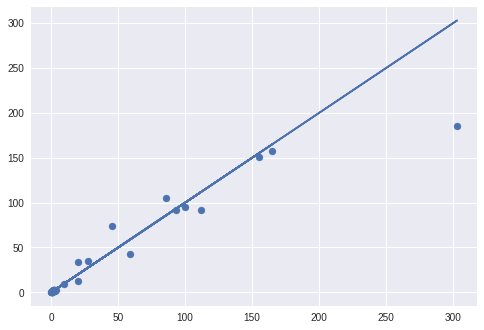

In [336]:
plt.scatter(np.exp(kepler_data_y_test), pred_ridge)
plt.plot(np.exp(kepler_data_y_test), np.exp(kepler_data_y_test))
plt.show()

In [316]:
errors_abs = np.abs(np.array(np.exp(kepler_data_y_test))-pred_ridge)
errors = np.array(np.exp(kepler_data_y_test)).reshape(40,1)-pred_ridge.reshape(40,1)

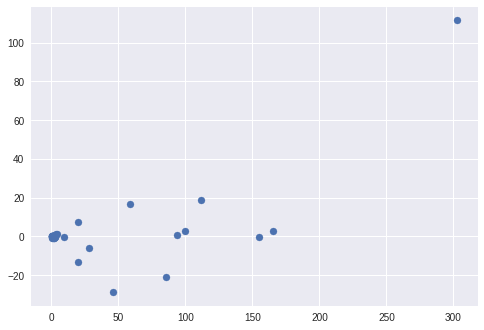

In [317]:
plt.scatter(np.array(np.exp(kepler_data_y_test)).reshape(40,1), errors)
plt.show()

## Linear Regression Model : Lasso

In [318]:
alphas = np.linspace(0.0001,1,1000)*0.5

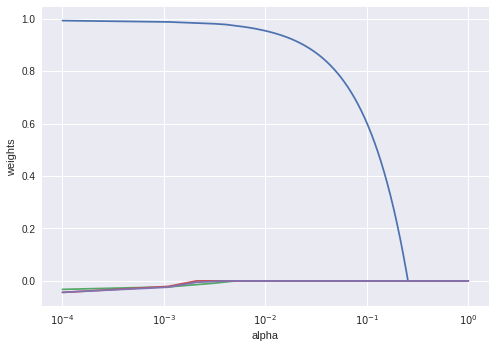

In [319]:
lasso = linear_model.Lasso(max_iter = 10000, normalize=True)
coeffs = []
for al in alphas:
    lasso.set_params(alpha=al)
    lasso.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
    coeffs.append(lasso.coef_)
ax = plt.gca()
ax.plot(2*alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [320]:
lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(np.array(kepler_data_stan_x_train), np.array(kepler_data_stan_y_train))
pred = lasso.predict(kepler_data_stan_x_test)
mean_squared_error(np.exp(kepler_data_y_test), np.exp((pred*kepler_data_y_test.std())+kepler_data_y_test.mean()))

354.87015771578268

In [321]:
print(pd.Series(lasso.coef_, index=kepler_data_stan_x_test.columns))
print("Intercept: ", lasso.intercept_)
print("Aplha: ", lasso.alpha)

SemiMajorAxis     0.992060
Volume           -0.030875
EscapeVelocity   -0.040400
Density          -0.040666
dtype: float64
Intercept:  1.65741600668e-16
Aplha:  0.000127135276359


In [322]:
pred_lasso = np.exp((lasso.predict(kepler_data_stan_x_test)*kepler_data_y_test.std())+kepler_data_y_test.mean())

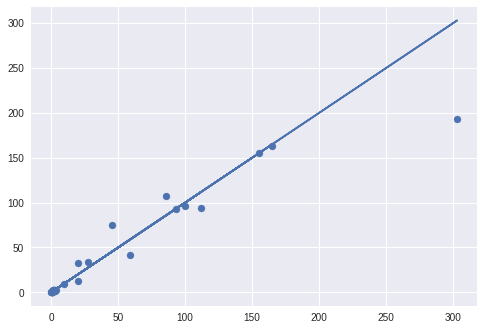

In [323]:
plt.scatter(np.exp(kepler_data_y_test), pred_lasso)
plt.plot(np.exp(kepler_data_y_test), np.exp(kepler_data_y_test))
plt.show()

In [324]:
errors_abs = np.abs(np.array(np.exp(kepler_data_y_test))-pred_lasso)
errors = np.array(np.exp(kepler_data_y_test)).reshape(40,1)-pred_lasso.reshape(40,1)

In [325]:
errors.mean()

2.2218856375095895

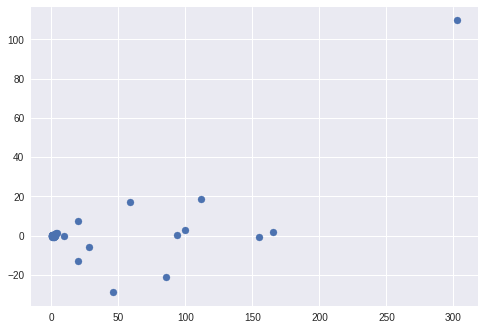

In [326]:
plt.scatter(np.array(np.exp(kepler_data_y_test)).reshape(40,1), errors)
plt.show()

## Histogram of Errors - Lasso

In [327]:
y = pd.DataFrame(errors)

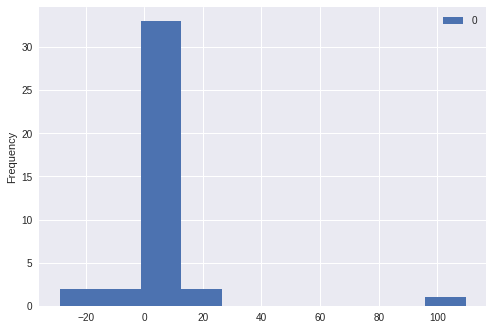

In [328]:
y.plot(kind = 'hist')
plt.show()

## Box Plot - Lasso

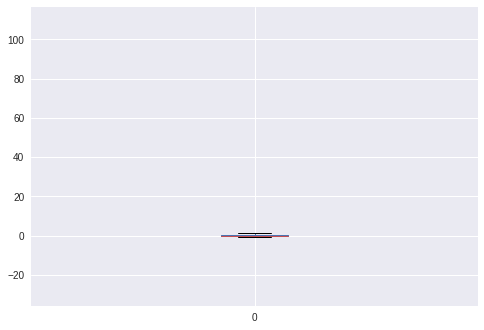

In [329]:
y.plot(kind = 'box')
plt.show()